# Introduction

Name: Henrik Jilke


Document classification is an essential building block of many machine learning applications,
and therefore important. The authors of the paper *ICDAR-2015 paper* [deepdocclassifier](https://ieeexplore.ieee.org/document/7333933/) have therefore taken the challenge to improve the
state of art performance (back in 2015) of document classification. Their method is different to existing solutions as they use deep convolutional networks and base their classification only on visual aspects.
 

This Notebook reimplements the proposed DeepDocClassifier model and training procedure as outlined
in the publication. For this we will cover:


**1. Process Data**:

[1 Process Data](#1-Process-Data)
* [1.1 Read Source Data](#1.1-Read-Source-Data)
* [1.2 Build Partitions](#1.2-Build-Partitions)
* [1.3 Split the Data](#1.3-Split-the-Data)
* [1.4 Plot Data](#1.4-Plot-Data)

**2. Modeling**:

[2 Modeling](#2-Modeling)
* [2.1 Create the Model](#2.1-Create-the-Model)
* [2.2 Train the Model](#2.2-Train-the-Model)

**3. Analyse Results**:

[3 Analyse Results](#3-Analyse-Results)
* [3.1 Accuracy vs Training size](#3.1-Accuracy-vs-Training-size)
* [3.2 Confusion Matrix](#3.2-Confusion-Matrix)



In [1]:
from sklearn.metrics import plot_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
import os
import torch

In [2]:
root = os.path.dirname(__name__)

# 1 Process Data

The *Tobacco3482* data set consists **3482** different documents. Every document
has an assigned category (class label), and there are a total of **10** different class labels.
Theses class labels are:
* Note, Scientific, Form, Report, ADVE, Memo, Resume, Email, News, Letter


The downloaded data set structures the different documents types in subfolders. For each
class label there is a subfolder, e.g. 10 subfolders in total. To read this
data I created a reader called *SourceReader* ([SourceReader](files/tobacco_data_set.py))



# 1.1 Read Source Data

We use our *SourceReader* ([SourceReader](files/tobacco_data_set.py)) to load and read the raw data

In [3]:
from tobacco_data_set import SourceReader

In [4]:
path_to_tabocco_data = os.path.abspath(os.path.join(root, "data/Tobacco3482-jpg"))
file_reader = SourceReader(path_to_tabocco_data)
labels = file_reader.read_class_labels()
data_dict = file_reader.get_image_paths(labels)

print(file_reader.read_class_labels())
print("Overall we have a total of {} images".format(sum(len(k) for v, k in data_dict.items())))

['Note', 'Scientific', 'Form', 'Report', 'ADVE', 'Memo', 'Resume', 'Email', 'News', 'Letter']
Overall we have a total of 3482 images


# 1.2 Build Partitions


To showcase the power of the method the authors measure the performance of their method on random partitions of the *Tobacco3482*. For detailed information, please see the *ICDAR-2015 paper* [deepdocclassifier](https://ieeexplore.ieee.org/document/7333933/)

The authors create 100 random partitions with different training sizes ranging for 20 to 100 samples for 
each class. As I do not have access to a GPU cluster I will create only 5 random partitions, such that
I have one partition with 20 training images per class, one with 40, etc.

As we use the Pytorch framework to build and train the neural network I have to make the *Tobacco3482* dataset is compatible with the framework. For this reason I created the *TobaccoDataSet* which ensures compatibility.

In [5]:
import random 
from tobacco_data_set import TobaccoDataSet, RandomPartitioner

def create_partition(data_dict, n_train_images):
    partitioner = RandomPartitioner(data_dict, n_train_images)
    train_partition, test_partition = partitioner.partition()
    return train_partition, test_partition


def create_set_of_partitions(data_dict, random_partitions, path_to_partitions):
    for n_train_images in random_partitions:
        train_partition, test_partition = create_partition(data_dict, n_train_images)

        train_data = TobaccoDataSet(train_partition, transform=transforms)
        test_data = TobaccoDataSet(test_partition, transform=transforms)

        file_name = "data-partition-{}-size_train-{}".format(uuid.uuid4(), n_train_images)
        file_path = os.path.join(path_to_partitions, file_name)
        data = [train_data, test_data]
        torch.save(data, file_path)

In [6]:
path_to_partitions = os.path.abspath("./partitions")
create_set_of_partitions(data_dict, [20, 40, 60, 80, 100], path_to_partition)

In the follwing we see all the partitions that were created

In [7]:
os.listdir(path_to_partitions)

['data-partition-6bac002e-b9d8-4e16-8a05-7912d06cc480-size_train-60',
 '.gitkeep',
 'data-partition-639d75cf-1d8a-4a15-a530-64cce86bcb5b-size_train-100',
 'data-partition-863d6a02-b3df-4b89-9a00-ef1818862146-size_train-80',
 'data-partition-a19e490f-c050-4230-92da-d42ee80335f4-size_train-40',
 'data-partition-6a372eda-fff1-430b-9fec-a4c5a0bc4f6d-size_train-20']

# 1.3 Split the Data

While training on each partition, the authors split the training data into validation data (20%) and training data (80%). For detailed information, please see the *ICDAR-2015 paper* [deepdocclassifier](https://ieeexplore.ieee.org/document/7333933/)

To do this, I created a helper function *train_validation_split* that splits the data into a validation set and a training set. Additionally, the authors resize the images to a size of (227, 277) which is why we create a *transforms* object


In [8]:
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

def train_validation_split(data_size, train_frac=0.8):
    indices = list(range(data_size))
    train_size = int((0.8 * data_size))
    np.random.shuffle(indices)
    train_indices, val_indices = indices[:train_size], indices[train_size+1:]
    return SubsetRandomSampler(train_indices), SubsetRandomSampler(val_indices)

transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((227,227))
]) 

# 1.4 Plot Data

To see if all works we plot two example documents

In [9]:
import matplotlib.pyplot

def plot_helper(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [10]:
train_partition, test_partition = create_partition(data_dict, 20)
train_data = TobaccoDataSet(train_partition, transform=transforms)

train_sampler, val_sampler = train_validation_split(len(train_data), train_frac=0.8)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, sampler=train_sampler)

As we can see all looks good

<Figure size 720x1080 with 0 Axes>

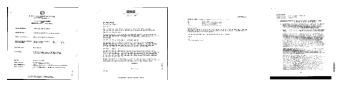

In [11]:
plt.figure(figsize=(10,15))
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(nrows=1, ncols=4)
for i, ax in enumerate(axes):
    plot_helper(images[i], ax=ax)
plt.show()

# 2 Modeling


The DeepDocClassifier is based on a pretrained *AlexNet*, that was initially trained on image net (1000 classes). To adapt the network for Tobacco3482 dataset we have to change the last layer of the *AlexNet* and replace it with a fully connected layer that has only 10 hidden units.

My reimplementation of the model ([Implementation](files/model.py)) swaps the last layer of the *AlexNet* and replaces it with a fully connected layer that has only 10 hidden units. As we can see below 


# 2.1 Create the Model

In [12]:
from model import DeepDocClassifier
from torchvision.models.alexnet import alexnet

model = DeepDocClassifier(alexnet, 10)
print(model)

DeepDocClassifier(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (glob_avg_pooling): AdaptiveAvgPool2d(output_size=(6, 6))
  (fc_layers): Sequential(
    (0): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_f

# 2.2 Train the Model

The training of neural networks is difficult based on the typical non-convexity of the loss
function and the vast amount of network/hyper parameters. Within the paper the authors provide useful guidelines on how to train the network.

Foremost, they use Stochastic Gradient Descent with a learning rate of 0.0001, momentum of 0.9, weight decay of 0.0005 and a batch size of 10. 

To ensure good generalisation, in other words avoid overfitting, the authors separate some fraction of the training data as validation data. I use this validation data for early stopping, e.g. once the network does not show improvement on the validation set.




In [13]:
from train import train_on_partitions

path_to_models = os.path.abspath("./models")
train_on_partitions(path_to_partitions=path_to_partitions, 
                    transforms=transforms, 
                    max_epochs=15, 
                    path_to_models=path_to_models)

In [14]:
os.listdir(path_to_models)

['.gitkeep',
 'model-partitionID-data-partition-863d6a02-b3df-4b89-9a00-ef1818862146-size_train-80',
 'model-partitionID-data-partition-6bac002e-b9d8-4e16-8a05-7912d06cc480-size_train-60',
 'model-partitionID-data-partition-a19e490f-c050-4230-92da-d42ee80335f4-size_train-40',
 'model-partitionID-data-partition-639d75cf-1d8a-4a15-a530-64cce86bcb5b-size_train-100',
 'model-partitionID-data-partition-6a372eda-fff1-430b-9fec-a4c5a0bc4f6d-size_train-20']

# 3 Analyse Results


Similar to the experiment section I report the accuracy for each partition size to get a feeling of how well the method scales with more training data. Moreover I report the confusion matrix


# 3.1 Accuracy vs Training size

In practice it is very important to understand how well the classifier performs if we increase the amount of training data. This also helps us to understand how sensitive
the model is if there is only very few training data available

For this reason we are going to plot the accuracy of the classifier vs. the amount of training data used.

In [15]:
def accuracy_vs_number_of_images(path_to_models, path_to_partitions):
    results = {}
    models = [m for m in os.listdir(path_to_models) if m.startswith("model")]
    for model_path in models:
        trained_partition = "data-partition-" + model_path[33:]
        _, test_set = torch.load(os.path.join(path_to_partitions, trained_partition))
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=32)
        model = DeepDocClassifier(alexnet, 10)
        model.load_state_dict(torch.load(os.path.join(path_to_models, model_path)))
        model.eval()
        accuracy = 0
        n_images = len(test_loader.dataset)

        for images, label in test_loader:
            predictions = model(images).detach().numpy() 
            label = label.detach().numpy() 
            accuracy += np.sum(np.argmax(predictions, axis=1) == label)

        results[model_path] = accuracy / n_images
    return results

In [16]:
results = accuracy_vs_number_of_images(path_to_models, path_to_partitions)

In [17]:
results

{'model-partitionID-data-partition-863d6a02-b3df-4b89-9a00-ef1818862146-size_train-80': 0.6755239520958084,
 'model-partitionID-data-partition-6bac002e-b9d8-4e16-8a05-7912d06cc480-size_train-60': 0.6075905292479109,
 'model-partitionID-data-partition-a19e490f-c050-4230-92da-d42ee80335f4-size_train-40': 0.5869140625,
 'model-partitionID-data-partition-639d75cf-1d8a-4a15-a530-64cce86bcb5b-size_train-100': 0.7277508090614887,
 'model-partitionID-data-partition-6a372eda-fff1-430b-9fec-a4c5a0bc4f6d-size_train-20': 0.5327017114914425}

In [18]:
def plot_accuracy_vs_number_of_images(x, y):
    plt.figure()
    y = np.array(y)*100
    plt.plot(x, y, 'o-')  
    plt.xticks([0] + x)
   
    plt.yticks(range(0, 100, 10))
    plt.xlabel("Number of images for training and validation per class")
    plt.ylabel("Accuracy (%)")
    plt.title("Comparison of the classification results on Tobaco-3482")
    plt.show()

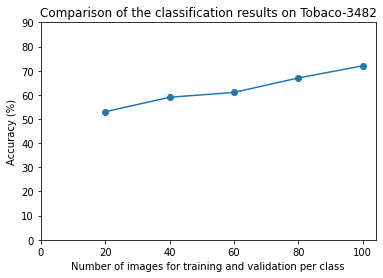

In [19]:
# As we have only 5 values we copy them from the results above 
plot_accuracy_vs_number_of_images([20, 40, 60, 80, 100], [0.53, 0.59, 0.61, 0.67, 0.72])

# 3.2 Confusion Matrix

In order to understand how to further improve the model confusion matrices are a very useful tool. Given the document classification, they allow us to understand how well the classifier predicts the different categories as well as which categories the classifier confuses.

For this reason I will provide the confusion matrix below


In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

DECODING_CLASS = [
     'Note',
     'Scientific',
     'Form',
     'Report',
     'ADVE',
     'Memo', 
     'Resume',
     'Email',
     'News',
     'Letter' 
]

def plot_confusion_matrix(predictions, labels, decoding_labels):
    conf_matrix = confusion_matrix(predictions, labels, normalize='true')
    df_cm = pd.DataFrame(
        conf_matrix*100, 
        index = [decoding_labels[i] for i in [4,7,2,9,5,8,0,3,6,1]], # order as in the paper
        columns = [decoding_labels[i] for i in [4,7,2,9,5,8,0,3,6,1]]# order as in the paper
    )
    plt.figure(figsize = (10,7))
    ax = plt.axes()
    sn.heatmap(df_cm, annot=True, cmap='Blues', ax=ax)
    
    acc = np.mean(np.array(predictions_list) == np.array(labels_list))
    ax.set_title("Recognition accuracy {:2f}%".format(acc * 100))
    plt.ylabel("Ground Truth")
    plt.show()

In [21]:
##################################################
# Please Modify to your custom model and partition
##################################################
model_file = "model-partitionID-data-partition-639d75cf-1d8a-4a15-a530-64cce86bcb5b-size_train-100"
partition_file = "data-partition-639d75cf-1d8a-4a15-a530-64cce86bcb5b-size_train-100"

_, test_set = torch.load(os.path.join(path_to_partitions, partition_file))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32)
model = DeepDocClassifier(alexnet, 10)
model.load_state_dict(torch.load(os.path.join(path_to_models, model_file)))
model.eval()

predictions_list = []
labels_list = []

for images, label in test_loader:
    predictions = model(images).detach().numpy() 
    predictions = np.argmax(predictions, axis=1)
    label = label.detach().numpy() 
    
    predictions_list += list(predictions)
    labels_list += list(label)

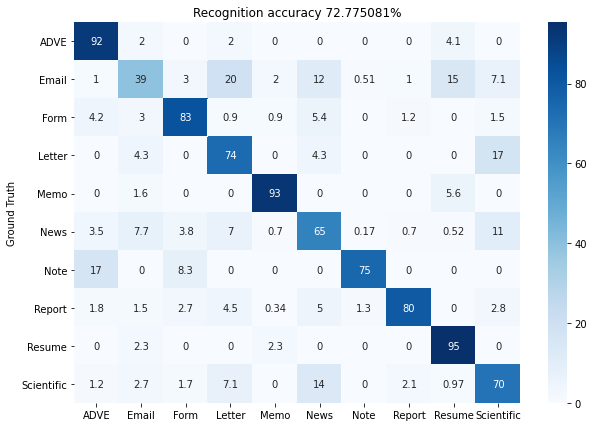

In [24]:
plot_confusion_matrix(predictions_list, labels_list, DECODING_CLASS)